# Importing required libraries

In [1]:
from pyforest import *
import warnings
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import metrics
from scipy.stats import f_oneway

In [2]:
warnings.filterwarnings('ignore')

# Loading the train and the test data

In [3]:
train = pd.read_csv(r"train.csv", index_col=0)
test = pd.read_csv(r"test.csv", index_col=0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Examining the class frequencies

In [4]:
train.is_invalid.value_counts()

0    1248223
1      69008
Name: is_invalid, dtype: int64

### Class imbalance is present

# Examining the first and last 20 rows of the train data

In [5]:
train.head(20)

,orderid,ordercustomeraddress,ordercustomercity,ordercustomerpincode,is_invalid
1,6977371.0,Flor Mil Palasgaw,Chandrapur,441222.0,1
2,6977101.0,"43, Gkw Layouts",Bangalore,560010.0,1
3,6977464.0,4_51_1,East Godavari,533239.0,1
4,6977628.0,"None, Khatla",Aizawl,796001.0,1
5,6977784.0,"None, Kulikawn",Aizawl,796001.0,1
6,7730650.0,Courier Point,Karim Nagar,505425.0,1
7,6977314.0,Manipal university Jaipur,Jaipur,303007.0,1
8,7758197.0,Ambary,Nalbari,781372.0,1
9,7758302.0,Ambary,Nalbari,781372.0,1
10,6977397.0,4_51_1,East Godavari,533239.0,1


In [6]:
train.tail(20)

,orderid,ordercustomeraddress,ordercustomercity,ordercustomerpincode,is_invalid
1317212,8380398.0,"Ward No 12, At Katangi,, At Katangi",Balaghat,481445.0,0
1317213,8386953.0,"Mandir Ke Pass Sirsala Ward No. 3, Village-Sir...",Dhar,454446.0,0
1317214,8380506.0,"MIG1st 121 NIRMALA SADAN, New Housing Board Co...",Umaria,484001.0,0
1317215,8409232.0,"naga mohalla,jumerati colony hoshangabad m.p, ...",Hoshangabad,461001.0,0
1317216,8390016.0,"146, Balaghat Shadi Hall K Pichhe, Mp",Balaghat,481001.0,0
1317217,8421662.0,Word No 26 Jumerati Kali mandir k piche shivna...,Hoshangabad,461001.0,0
1317218,8394161.0,"271/2a Saket Nagar Aims Ke Samne Urmila Tower,...",Bhopal,462024.0,0
1317219,8408449.0,"Front Of Dr. Shrivastav, Shanti Niketan Road,B...",Ujjain,456771.0,0
1317220,8378178.0,"DM 109 Ayodhya Extension Bhopal, Ayodhya Exten...",Bhopal,462041.0,0
1317221,8386008.0,"Kanya Sala Marge Mahidpur Road, Kanya Sala Marge",Ujjain,456440.0,0


### Data seem to be arranged in a format where the invalid address are at the first and the valid address are at the last. Data doesn't seem to be sampled at random.

# Investigating a couple of valid adderess

In [7]:
train[-2:].ordercustomeraddress.values

array(['Kapil Agarwal Basia Mohalla Nageshwar Mandir K Piche Sagar  MP ',
       'Sindhi coloney Gali No 1 Front Of Muthot Finance, Sindhi Coloney Gali No 1 Itarsii'],
      dtype=object)

# Feature engineering and Augmentation

### Concatenated the customer address and the customer city in order to capture complete information. It is assumed that in a vector space, valid address along with valid city will cluster together and those address which are invalid will be far away from cluster and hence a pattern might arise which might help the algorithm to generalize better. Here 'full_address' is an augmented feature

In [8]:
train['full_address'] = train.loc[train.is_invalid == 1,'ordercustomeraddress'] +' '+  train.loc[train.is_invalid == 1,'ordercustomercity']

In [9]:
test['full_address'] = test.loc[test.is_invalid == 1,'ordercustomeraddress'] +' '+  test.loc[test.is_invalid == 1,'ordercustomercity']

In [10]:
train.full_address.fillna(train.ordercustomeraddress, inplace = True)

In [11]:
test.full_address.fillna(test.ordercustomeraddress, inplace = True)

## Text cleaning and preprocessing

In [12]:
def text_process(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r'_','',text)
    text = re.sub(r'\d','number ',text)
    text = re.sub(r'none','',text)
    text = text.strip()
    return text

# Now using the newly created feature, 'full_address', we can clean the address and strip of any punctuations and also replace any numeric values with the word 'number' as a number in the address doesn't contribute much during learning phase. Also duplicate rows were removed as a part of cleaning procedure.

In [13]:
train['processed_ordercustomeraddress'] = train.apply(lambda x: text_process(x['full_address']), axis = 1)

In [14]:
train = train[~train.processed_ordercustomeraddress.duplicated()]

In [15]:
test['processed_ordercustomeraddress'] = test.apply(lambda x: text_process(x['full_address']), axis = 1)

In [16]:
test = test[~test.processed_ordercustomeraddress.duplicated()]

# Another augmented feature, 'processed_ordercustomeraddress_len' which will capture the number of words / token for a given address. As per the below visulization, there is a signifant difference in distrubution of the frequency of tokens for both valid and invalid address which is established in line no. 63 

In [17]:
def feature_maker(text):
    tok = []
    tokens = word_tokenize(text)
    l = len(tokens)
    return l

In [18]:
train['processed_ordercustomeraddress_len'] = train.apply(lambda x: feature_maker(x['processed_ordercustomeraddress']), axis= 1)

In [19]:
test['processed_ordercustomeraddress_len'] = test.apply(lambda x: feature_maker(x['processed_ordercustomeraddress']), axis= 1)

In [20]:
train.head()

,orderid,ordercustomeraddress,ordercustomercity,ordercustomerpincode,is_invalid,full_address,processed_ordercustomeraddress,processed_ordercustomeraddress_len
1,6977371.0,Flor Mil Palasgaw,Chandrapur,441222.0,1,Flor Mil Palasgaw Chandrapur,flor mil palasgaw chandrapur,4
2,6977101.0,"43, Gkw Layouts",Bangalore,560010.0,1,"43, Gkw Layouts Bangalore",number number gkw layouts bangalore,5
3,6977464.0,4_51_1,East Godavari,533239.0,1,4_51_1 East Godavari,number number number number east godavari,6
4,6977628.0,"None, Khatla",Aizawl,796001.0,1,"None, Khatla Aizawl",khatla aizawl,2
5,6977784.0,"None, Kulikawn",Aizawl,796001.0,1,"None, Kulikawn Aizawl",kulikawn aizawl,2


In [21]:
train.tail()

,orderid,ordercustomeraddress,ordercustomercity,ordercustomerpincode,is_invalid,full_address,processed_ordercustomeraddress,processed_ordercustomeraddress_len
1317215,8409232.0,"naga mohalla,jumerati colony hoshangabad m.p, ...",Hoshangabad,461001.0,0,"naga mohalla,jumerati colony hoshangabad m.p, ...",naga mohallajumerati colony hoshangabad mp nag...,13
1317216,8390016.0,"146, Balaghat Shadi Hall K Pichhe, Mp",Balaghat,481001.0,0,"146, Balaghat Shadi Hall K Pichhe, Mp",number number number balaghat shadi hall k pi...,9
1317217,8421662.0,Word No 26 Jumerati Kali mandir k piche shivna...,Hoshangabad,461001.0,0,Word No 26 Jumerati Kali mandir k piche shivna...,word no number number jumerati kali mandir k ...,25
1317218,8394161.0,"271/2a Saket Nagar Aims Ke Samne Urmila Tower,...",Bhopal,462024.0,0,"271/2a Saket Nagar Aims Ke Samne Urmila Tower,...",number number number number a saket nagar aims...,15
1317219,8408449.0,"Front Of Dr. Shrivastav, Shanti Niketan Road,B...",Ujjain,456771.0,0,"Front Of Dr. Shrivastav, Shanti Niketan Road,B...",front of dr shrivastav shanti niketan roadbarn...,7


In [22]:
train.loc[train.is_invalid == 1, 'processed_ordercustomeraddress_len'].describe()

count    56000.000000
mean        11.189696
std          7.063588
min          1.000000
25%          7.000000
50%         10.000000
75%         14.000000
max        119.000000
Name: processed_ordercustomeraddress_len, dtype: float64

In [23]:
train.loc[train.is_invalid == 1, 'processed_ordercustomeraddress_len'].mode()

0    8
dtype: int64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

([<matplotlib.axis.XTick at 0x16f6b79a6c8>,
 <a list of 12 Text xticklabel objects>)

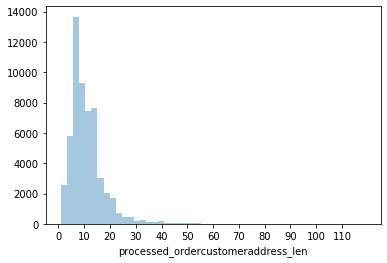

In [24]:
sns.distplot(train.loc[train.is_invalid == 1, 'processed_ordercustomeraddress_len'], kde = False)
plt.xticks(ticks=range(0,120,10))

<IPython.core.display.Javascript object>

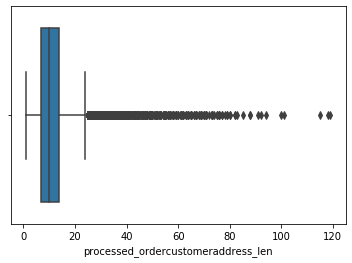

In [25]:
sns.boxplot(train.loc[train.is_invalid == 1, 'processed_ordercustomeraddress_len'])


In [26]:
train.loc[train.is_invalid == 0, 'processed_ordercustomeraddress_len'].describe()

count    609477.000000
mean         12.626270
std           6.919399
min           1.000000
25%           8.000000
50%          11.000000
75%          15.000000
max         294.000000
Name: processed_ordercustomeraddress_len, dtype: float64

In [27]:
train.loc[train.is_invalid == 0, 'processed_ordercustomeraddress_len'].mode()

0    10
dtype: int64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

([<matplotlib.axis.XTick at 0x16f63d958c8>,
 <a list of 15 Text xticklabel objects>)

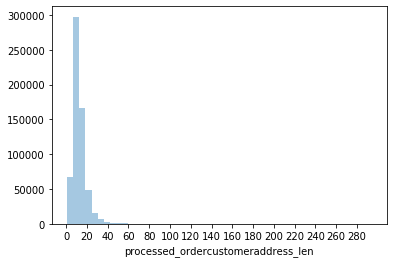

In [28]:
sns.distplot(train.loc[train.is_invalid == 0,'processed_ordercustomeraddress_len'], kde = False)
plt.xticks(ticks=range(0,300,20))

<IPython.core.display.Javascript object>

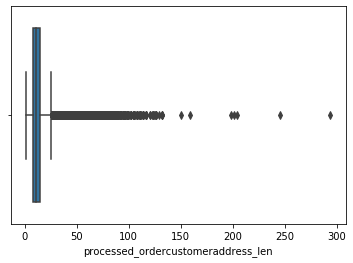

In [29]:
sns.boxplot(train.loc[train.is_invalid == 0,'processed_ordercustomeraddress_len'])


In [63]:
f_oneway(train.loc[train.is_invalid == 1,'processed_ordercustomeraddress_len'], train.loc[train.is_invalid == 0,'processed_ordercustomeraddress_len'])

F_onewayResult(statistic=2202.9002893218176, pvalue=0.0)

# Since p value is less than 0.5 hence there is a significant difference in mean between two groups. Hence we fail to access null hypothesis (which is there is no significant difference in mean between two groups)

# Converting text into vectors using Counter Vectorizer and Term Freq Inverse Document Frequency Vectorizer. Here we have to horizontally stack the word embeddings with the augemented features. The below UDF will create ML ready vector

### Setting up instances for Count Vec and Tf-IDF Vec

In [30]:
cvec = CountVectorizer()
tfidf = TfidfVectorizer()

In [31]:
def freqBasedSentenceEmbedder(train, test, sentenceColName, encodedClassColName, otherFeatureColName):
    tfidf.fit(train[sentenceColName])
    cvec.fit(train[sentenceColName])
    X_train_stacked_tfidf = hstack([tfidf.transform(train[sentenceColName]), csr_matrix(train[otherFeatureColName].values).transpose()])
    X_train_stacked_cvec = hstack([cvec.transform(train[sentenceColName]), csr_matrix(train[otherFeatureColName].values).transpose()])
    X_test_stacked_tfidf = hstack([tfidf.transform(test[sentenceColName]), csr_matrix(test[otherFeatureColName].values).transpose()])
    X_test_stacked_cvec = hstack([cvec.transform(test[sentenceColName]), csr_matrix(test[otherFeatureColName].values).transpose()])
    return X_train_stacked_tfidf, X_train_stacked_cvec, X_test_stacked_tfidf, X_test_stacked_cvec, train[
        encodedClassColName], test[encodedClassColName]

In [32]:
X_train_stacked_tfidf, X_train_stacked_cvec, X_test_stacked_tfidf, X_test_stacked_cvec, y_train, y_test = freqBasedSentenceEmbedder(train,test,'processed_ordercustomeraddress','is_invalid','processed_ordercustomeraddress_len')

### Setting up instances for Logistic Regression and Linear SVC. Setting the class weight to balanced so that it takes care of the imbalanced dataset.

In [42]:
lr = LogisticRegression(class_weight='balanced',max_iter=1000)
svm = LinearSVC(class_weight='balanced', max_iter=1000)

### Training LR using Count Vec

In [43]:
lr_cvec = lr.fit(X_train_stacked_cvec, y_train)

### Training LR using Tf-IDF Vec

In [44]:
lr_tfidf = lr.fit(X_train_stacked_tfidf, y_train)

### Training Linear SVC using Count Vec

In [45]:
svm_cvec = svm.fit(X_train_stacked_cvec, y_train)

### Training LR using Tf-IDF Vec

In [46]:
svm_tfidf = svm.fit(X_train_stacked_tfidf, y_train)

# Model Evaluation

### Classification Report for LR using CVEC

In [47]:
print(metrics.classification_report(y_test, lr_cvec.predict(X_test_stacked_cvec)))

              precision    recall  f1-score   support

           0       0.99      0.80      0.88    275280
           1       0.15      0.76      0.25     12765

    accuracy                           0.80    288045
   macro avg       0.57      0.78      0.57    288045
weighted avg       0.95      0.80      0.85    288045



### Classification Report for LR using Tf-IDF

In [48]:
print(metrics.classification_report(y_test, lr_tfidf.predict(X_test_stacked_tfidf)))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83    275280
           1       0.13      0.93      0.23     12765

    accuracy                           0.72    288045
   macro avg       0.56      0.82      0.53    288045
weighted avg       0.96      0.72      0.80    288045



### Classification Report for Linear SVC using CVEC

In [49]:
print(metrics.classification_report(y_test, svm_cvec.predict(X_test_stacked_cvec)))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86    275280
           1       0.14      0.84      0.24     12765

    accuracy                           0.76    288045
   macro avg       0.56      0.80      0.55    288045
weighted avg       0.95      0.76      0.83    288045



### Classification Report for Linear SVC using Tf-IDF

In [50]:
print(metrics.classification_report(y_test, svm_tfidf.predict(X_test_stacked_tfidf)))

              precision    recall  f1-score   support

           0       0.99      0.75      0.85    275280
           1       0.14      0.88      0.24     12765

    accuracy                           0.75    288045
   macro avg       0.57      0.81      0.54    288045
weighted avg       0.95      0.75      0.82    288045



# So it is observed that Linear SVC with Tf-IDF word embedding has a slightly better Recall and F1 score in expense of lower Accuracy and Precision as compared to other models. Assuming we want to minimize RTO as much as possible, we should focus on Recall as we don't want to miss out on detecing a invalid address in expense of false positives.

## We didn't choose logistic because it has a higher recall and high recall means more False Positives. In order to strike a balance, we went for Linear SVC

In [56]:
pred = svm_tfidf.predict(X_test_stacked_tfidf)

# Precision Score

In [57]:
print(metrics.precision_score(y_test, pred))

0.13797896549603297


# Recall Score

In [58]:
print(metrics.recall_score(y_test, pred))

0.8787309048178613


# Accuracy

In [59]:
print(metrics.accuracy_score(y_test, pred))

0.7513374646322624


# Confusion Matrix

In [60]:
cm = pd.DataFrame(metrics.confusion_matrix(y_test,pred))
cm

<IPython.core.display.Javascript object>

,0,1
0,205202,70078
1,1548,11217


# Improvement Ideas:
    1. Use 512/128 dim Universal Sentence Encoder
    2. Perform Cross Validation
    3. Tune the cut off probability threshold (have to use platt scaling for SVC)
    4. Can also use BERT/ AlBERT/ DistilBert for word embedding.
    5. Can also perform class balancing by either collecting more data for invalid address or data augmentation techniques
    6. Can also perform k-fold cross validation (unable to perfrom curently due to weak hardware)
    7. Collect more data on invalid address
    8. Can also perform classification using DNN
    9. Can also collect lat and long and convert them into s2 cell ids and then trying to match the provided address location with all possible address in that cell. 